<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/src/notebooks/k_means/cluster_yolo_images_by_k_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains examples of various clustering techniques applied to feral cat images.  Photos of feral cats are first passed through a YOLO v8 instance segmentation model trained on the feral cat image dataset, yielding a set of files in which each file contains a segmented image of one cat extracted from the photo using one of the predicted masks output by the model for that photo.  Once this step is performed, the output files can be saved and used directly in the clustering experiments without having to rerun the photos from the instance segmentation model.

The individual cat images are then run through a VGG16 model trained on the COCO dataset (which includes cats as an object class) and the feature vectors of the images are computed.  The feature vectors are of shape (-1, 4096), and are reduced via PCA to shape (-1, min(100, # of segmented files)).  These reduced-dimensionality feature vectors are then clustered using various algorithms.

In [1]:
# for loading/processing the images
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import layers

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# image display
import IPython.display as display
from PIL import Image

# for everything else
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import tensorflow as tf
import cv2

!pip install ultralytics
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.0/705.0 kB 6.8 MB/s eta 0:00:00


In [2]:
# Get access to Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
path_to_instance_segmentation_model = '/content/gdrive/MyDrive/Cat images/models/feral-cat-segmentation.v1i.yolov8/200-epochs-/weights/best.pt'
path_to_segmented_images = '/content/unusable-selections-segmented'
segmented_image_wildcard_filetype = '*.png' # File type, expressed as wildcard, of segmented images in above folder

In [4]:
instance_segmentation_model = YOLO(path_to_instance_segmentation_model)  # load the feral cat instance segmentation model

In [5]:
# Parameters for feature clustering model
INPUT_SHAPE = (224,224, 3) ## Pixel size of images accepted by VGG, in each of 3 channels
IMG_SIZE = INPUT_SHAPE[:2]

In [6]:
# load VGG model for image clustering
image_cluster_model = VGG16()
# remove the output layer
image_cluster_model = Model(inputs=image_cluster_model.inputs, outputs=image_cluster_model.layers[-2].output)

553467096/553467096 [==============================] - 13s 0us/step


In [7]:
# Extract feature vector from a photo using a feature-extraction model
def extract_features(file, model, img_size=IMG_SIZE):
    # load the image as a 224x224 array
    img = load_img(file, target_size=img_size)
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = np.expand_dims(img, axis=0)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [8]:
# from https://github.com/arvkevi/kneed/blob/main/kneed/knee_locator.py
# Implementation of Kneedle algorithm at repo https://github.com/arvkevi/kneed
# for theoretical discussion of Kneedle, see https://towardsdatascience.com/detecting-knee-elbow-points-in-a-graph-d13fc517a63c
import numpy as np
from scipy import interpolate
from scipy.signal import argrelextrema
from typing import Tuple, Optional, Iterable

VALID_CURVE = ["convex", "concave"]
VALID_DIRECTION = ["increasing", "decreasing"]

try:
    import matplotlib.pyplot as plt
except ImportError:
    _has_matplotlib = False
    _matplotlib_not_found_err = ModuleNotFoundError(
        "This function needs Matplotlib to be executed. Please run command `pip install kneed[plot]` "
    )
else:
    _has_matplotlib = True


class KneeLocator(object):
    """
    Once instantiated, this class attempts to find the point of maximum
    curvature on a line. The knee is accessible via the `.knee` attribute.

    :param x: x values, must be the same length as y.
    :type x: 1D array of shape (`number_of_y_values`,) or list
    :param y: y values, must be the same length as x.
    :type y: 1D array of shape (`number_of_y_values`,) or list
    :param S: Sensitivity, the number of minimum number of data points below the local distance maximum before calling a knee. The original paper suggests default of 1.0
    :type S: float
    :param curve: If 'concave', algorithm will detect knees. If 'convex', it
        will detect elbows.
    :type curve: str
    :param direction: one of {"increasing", "decreasing"}
    :type direction: str
    :param interp_method: one of {"interp1d", "polynomial"}
    :type interp_method: str
    :param online: kneed will correct old knee points if True, will return first knee if False
    :type online: bool
    :param polynomial_degree: The degree of the fitting polynomial. Only used when interp_method="polynomial". This argument is passed to numpy polyfit `deg` parameter.
    :type polynomial_degree: int
    :ivar x: x values.
    :vartype x: array-like
    :ivar y: y values.
    :vartype y: array-like
    :ivar S: Sensitivity, original paper suggests default of 1.0
    :vartype S: integer
    :ivar curve: If 'concave', algorithm will detect knees. If 'convex', it
        will detect elbows.
    :vartype curve: str
    :ivar direction: one of {"increasing", "decreasing"}
    :vartype direction: str
    :ivar interp_method: one of {"interp1d", "polynomial"}
    :vartype interp_method: str
    :ivar online: kneed will correct old knee points if True, will return first knee if False
    :vartype online: str
    :ivar polynomial_degree: The degree of the fitting polynomial. Only used when interp_method="polynomial". This argument is passed to numpy polyfit `deg` parameter.
    :vartype polynomial_degree: int
    :ivar N: The number of `x` values in the
    :vartype N: integer
    :ivar all_knees: A set containing all the x values of the identified knee points.
    :vartype all_knees: set
    :ivar all_norm_knees: A set containing all the normalized x values of the identified knee points.
    :vartype all_norm_knees: set
    :ivar all_knees_y: A list containing all the y values of the identified knee points.
    :vartype all_knees_y: list
    :ivar all_norm_knees_y: A list containing all the normalized y values of the identified knee points.
    :vartype all_norm_knees_y: list
    :ivar Ds_y: The y values from the fitted spline.
    :vartype Ds_y: numpy array
    :ivar x_normalized: The normalized x values.
    :vartype x_normalized: numpy array
    :ivar y_normalized: The normalized y values.
    :vartype y_normalized: numpy array
    :ivar x_difference: The x values of the difference curve.
    :vartype x_difference: numpy array
    :ivar y_difference: The y values of the difference curve.
    :vartype y_difference: numpy array
    :ivar maxima_indices: The indices of each of the maxima on the difference curve.
    :vartype maxima_indices: numpy array
    :ivar maxima_indices: The indices of each of the maxima on the difference curve.
    :vartype maxima_indices: numpy array
    :ivar x_difference_maxima: The x values from the difference curve where the local maxima are located.
    :vartype x_difference_maxima: numpy array
    :ivar y_difference_maxima: The y values from the difference curve where the local maxima are located.
    :vartype y_difference_maxima: numpy array
    :ivar minima_indices: The indices of each of the minima on the difference curve.
    :vartype minima_indices: numpy array
    :ivar minima_indices: The indices of each of the minima on the difference curve.
    :vartype maxima_indices: numpy array
    :ivar x_difference_minima: The x values from the difference curve where the local minima are located.
    :vartype x_difference_minima: numpy array
    :ivar y_difference_minima: The y values from the difference curve where the local minima are located.
    :vartype y_difference_minima: numpy array
    :ivar Tmx: The y values that correspond to the thresholds on the difference curve for determining the knee point.
    :vartype Tmx: numpy array
    :ivar knee: The x value of the knee point. None if no knee/elbow was detected.
    :vartype knee: float
    :ivar knee_y: The y value of the knee point. None if no knee/elbow was detected
    :vartype knee_y: float
    :ivar norm_knee: The normalized x value of the knee point. None if no knee/elbow was detected
    :vartype norm_knee: float
    :ivar norm_knee_y: The normalized y value of the knee point. None if no knee/elbow was detected
    :vartype norm_knee_y: float
    :ivar all_knees: The x values of all the identified knee points.
    :vartype all_knees: set
    :ivar all_knees_y: The y values of all the identified knee points.
    :vartype all_knees: set
    :ivar all_norm_knees: The normalized x values of all the identified knee points.
    :vartype all_norm_knees: set
    :ivar all_norm_knees_y: The normalized y values of all the identified knee points.
    :vartype all_norm_knees: set
    :ivar elbow: The x value of the elbow point (elbow and knee are interchangeable). None if no knee/elbow was detected
    :vartype elbow: float
    :ivar elbow_y: The y value of the knee point (elbow and knee are interchangeable). None if no knee/elbow was detected
    :vartype elbow_y: float
    :ivar norm_elbow: The normalized x value of the knee point (elbow and knee are interchangeable). None if no knee/elbow was detected
    :vartype norm_knee: float
    :ivar norm_elbow_y: The normalized y value of the knee point (elbow and knee are interchangeable). None if no knee/elbow was detected
    :vartype norm_elbow_y: float
    :ivar all_elbows: The x values of all the identified knee points (elbow and knee are interchangeable).
    :vartype all_elbows: set
    :ivar all_elbows_y: The y values of all the identified knee points (elbow and knee are interchangeable).
    :vartype all_elbows: set
    :ivar all_norm_elbows: The normalized x values of all the identified knee points (elbow and knee are interchangeable).
    :vartype all_norm_elbows: set
    :ivar all_norm_elbows_y: The normalized y values of all the identified knee points (elbow and knee are interchangeable).
    :vartype all_norm_elbows: set
    """

    def __init__(
        self,
        x: Iterable[float],
        y: Iterable[float],
        S: float = 1.0,
        curve: str = "concave",
        direction: str = "increasing",
        interp_method: str = "interp1d",
        online: bool = False,
        polynomial_degree: int = 7,
    ):
        # Step 0: Raw Input
        self.x = np.array(x)
        self.y = np.array(y)
        self.curve = curve
        self.direction = direction
        self.N = len(self.x)
        self.S = S
        self.all_knees = set()
        self.all_norm_knees = set()
        self.all_knees_y = []
        self.all_norm_knees_y = []
        self.online = online
        self.polynomial_degree = polynomial_degree

        # I'm implementing Look Before You Leap (LBYL) validation for direction
        # and curve arguments. This is not preferred in Python. The motivation
        # is that the logic inside the conditional once y_difference[j] is less
        # than threshold in find_knee() could have been evaluated improperly if
        # they weren't one of convex, concave, increasing, or decreasing,
        # respectively.
        valid_curve = self.curve in VALID_CURVE
        valid_direction = self.direction in VALID_DIRECTION
        if not all((valid_curve, valid_direction)):
            raise ValueError(
                "Please check that the curve and direction arguments are valid."
            )

        # Step 1: fit a smooth line
        if interp_method == "interp1d":
            uspline = interpolate.interp1d(self.x, self.y)
            self.Ds_y = uspline(self.x)
        elif interp_method == "polynomial":
            p = np.poly1d(np.polyfit(x, y, self.polynomial_degree))
            self.Ds_y = p(x)
        else:
            raise ValueError(
                "{} is an invalid interp_method parameter, use either 'interp1d' or 'polynomial'".format(
                    interp_method
                )
            )

        # Step 2: normalize values
        self.x_normalized = self.__normalize(self.x)
        self.y_normalized = self.__normalize(self.Ds_y)

        # Step 3: Calculate the Difference curve
        self.y_normalized = self.transform_y(
            self.y_normalized, self.direction, self.curve
        )
        # normalized difference curve
        self.y_difference = self.y_normalized - self.x_normalized
        self.x_difference = self.x_normalized.copy()

        # Step 4: Identify local maxima/minima
        # local maxima
        self.maxima_indices = argrelextrema(self.y_difference, np.greater_equal)[0]
        self.x_difference_maxima = self.x_difference[self.maxima_indices]
        self.y_difference_maxima = self.y_difference[self.maxima_indices]

        # local minima
        self.minima_indices = argrelextrema(self.y_difference, np.less_equal)[0]
        self.x_difference_minima = self.x_difference[self.minima_indices]
        self.y_difference_minima = self.y_difference[self.minima_indices]

        # Step 5: Calculate thresholds
        self.Tmx = self.y_difference_maxima - (
            self.S * np.abs(np.diff(self.x_normalized).mean())
        )

        # Step 6: find knee
        self.knee, self.norm_knee = self.find_knee()

        # Step 7: If we have a knee, extract data about it
        self.knee_y = self.norm_knee_y = None
        if self.knee:
            self.knee_y = self.y[self.x == self.knee][0]
            self.norm_knee_y = self.y_normalized[self.x_normalized == self.norm_knee][0]

    @staticmethod
    def __normalize(a: Iterable[float]) -> Iterable[float]:
        """normalize an array
        :param a: The array to normalize
        """
        return (a - min(a)) / (max(a) - min(a))

    @staticmethod
    def transform_y(y: Iterable[float], direction: str, curve: str) -> float:
        """transform y to concave, increasing based on given direction and curve"""
        # convert elbows to knees
        if direction == "decreasing":
            if curve == "concave":
                y = np.flip(y)
            elif curve == "convex":
                y = y.max() - y
        elif direction == "increasing" and curve == "convex":
            y = np.flip(y.max() - y)

        return y

    def find_knee(
        self,
    ):
        """This function is called when KneeLocator is instantiated. It identifies the knee value and sets the instance attributes."""
        if not self.maxima_indices.size:
            # No local maxima found in the difference curve
            # The line is probably not polynomial, try plotting
            # the difference curve with plt.plot(knee.x_difference, knee.y_difference)
            # Also check that you aren't mistakenly setting the curve argument
            return None, None
        # placeholder for which threshold region i is located in.
        maxima_threshold_index = 0
        minima_threshold_index = 0
        traversed_maxima = False
        # traverse the difference curve
        for i, x in enumerate(self.x_difference):
            # skip points on the curve before the the first local maxima
            if i < self.maxima_indices[0]:
                continue

            j = i + 1

            # reached the end of the curve
            if i == (len(self.x_difference) - 1):
                break

            # if we're at a local max, increment the maxima threshold index and continue
            if (self.maxima_indices == i).any():
                threshold = self.Tmx[maxima_threshold_index]
                threshold_index = i
                maxima_threshold_index += 1
            # values in difference curve are at or after a local minimum
            if (self.minima_indices == i).any():
                threshold = 0.0
                minima_threshold_index += 1

            if self.y_difference[j] < threshold:
                if self.curve == "convex":
                    if self.direction == "decreasing":
                        knee = self.x[threshold_index]
                        norm_knee = self.x_normalized[threshold_index]
                    else:
                        knee = self.x[-(threshold_index + 1)]
                        norm_knee = self.x_normalized[threshold_index]

                elif self.curve == "concave":
                    if self.direction == "decreasing":
                        knee = self.x[-(threshold_index + 1)]
                        norm_knee = self.x_normalized[threshold_index]
                    else:
                        knee = self.x[threshold_index]
                        norm_knee = self.x_normalized[threshold_index]

                # add the y value at the knee
                y_at_knee = self.y[self.x == knee][0]
                y_norm_at_knee = self.y_normalized[self.x_normalized == norm_knee][0]
                if knee not in self.all_knees:
                    self.all_knees_y.append(y_at_knee)
                    self.all_norm_knees_y.append(y_norm_at_knee)

                # now add the knee
                self.all_knees.add(knee)
                self.all_norm_knees.add(norm_knee)

                # if detecting in offline mode, return the first knee found
                if self.online is False:
                    return knee, norm_knee

        if self.all_knees == set():
            # No knee was found
            return None, None

        return knee, norm_knee

    def plot_knee_normalized(
        self,
        figsize: Optional[Tuple[int, int]] = None,
        title: str = "Normalized Knee Point",
        xlabel: Optional[str] = None,
        ylabel: Optional[str] = None,
    ):
        """Plot the normalized curve, the difference curve (x_difference, y_normalized) and the knee, if it exists.

        :param figsize: Optional[Tuple[int, int]
            The figure size of the plot. Example (12, 8)
        :param title: str
            Title of the visualization, defaults to "Normalized Knee Point"
        :param xlabel: Optional[str]
            X-axis label
        :param ylabel: Optional[str]
            y-axis label
        :return: NoReturn
        """
        if not _has_matplotlib:
            raise _matplotlib_not_found_err

        if figsize is None:
            figsize = (6, 6)

        plt.figure(figsize=figsize)
        plt.title(title)
        if xlabel:
            plt.xlabel(xlabel)
        if ylabel:
            plt.ylabel(ylabel)
        plt.plot(self.x_normalized, self.y_normalized, "b", label="normalized curve")
        plt.plot(self.x_difference, self.y_difference, "r", label="difference curve")
        plt.xticks(
            np.arange(self.x_normalized.min(), self.x_normalized.max() + 0.1, 0.1)
        )
        plt.yticks(
            np.arange(self.y_difference.min(), self.y_normalized.max() + 0.1, 0.1)
        )

        plt.vlines(
            self.norm_knee,
            plt.ylim()[0],
            plt.ylim()[1],
            linestyles="--",
            label="knee/elbow",
        )
        plt.legend(loc="best")

    def plot_knee(
        self,
        figsize: Optional[Tuple[int, int]] = None,
        title: str = "Knee Point",
        xlabel: Optional[str] = None,
        ylabel: Optional[str] = None,
    ):
        """
        Plot the curve and the knee, if it exists

        :param figsize: Optional[Tuple[int, int]
            The figure size of the plot. Example (12, 8)
        :param title: str
            Title of the visualization, defaults to "Knee Point"
        :param xlabel: Optional[str]
            X-axis label
        :param ylabel: Optional[str]
            y-axis label
        :return: NoReturn
        """
        if not _has_matplotlib:
            raise _matplotlib_not_found_err

        if figsize is None:
            figsize = (6, 6)

        plt.figure(figsize=figsize)
        plt.title(title)
        if xlabel:
            plt.xlabel(xlabel)
        if ylabel:
            plt.ylabel(ylabel)
        plt.plot(self.x, self.y, "b", label="data")
        plt.vlines(
            self.knee, plt.ylim()[0], plt.ylim()[1], linestyles="--", label="knee/elbow"
        )
        plt.legend(loc="best")

    # Niceties for users working with elbows rather than knees
    @property
    def elbow(self):
        return self.knee

    @property
    def norm_elbow(self):
        return self.norm_knee

    @property
    def elbow_y(self):
        return self.knee_y

    @property
    def norm_elbow_y(self):
        return self.norm_knee_y

    @property
    def all_elbows(self):
        return self.all_knees

    @property
    def all_norm_elbows(self):
        return self.all_norm_knees

    @property
    def all_elbows_y(self):
        return self.all_knees_y

    @property
    def all_norm_elbows_y(self):
        return self.all_norm_knees_y

In [ ]:
import zipfile
!unzip unusable-selections-segmented.zip

In [ ]:
# Compile a list of all the extracted segmented images
import glob
image_paths = []
# get all image paths in folder with extracted segmented images
for path in glob.glob(os.path.join(path_to_segmented_images, segmented_image_wildcard_filetype)):
    image_paths.append(path)
# sort image_path
image_paths.sort()
image_paths

Given a set of paths to the segmented images (each one of an individual cat), reduce their dimensionality using PCA and cluster the results using KMeans, with the number of clusters ranging from 1 to the number of files (since each could be of a different cat).

1/1 [==============================] - 0s 27ms/step


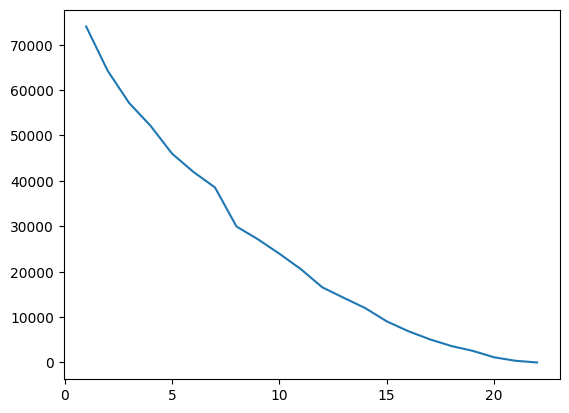

In [11]:
# Extract the features from each image
data = {}
for segmented_image_file in image_paths:
  feature = extract_features(os.path.join(path_to_segmented_images, segmented_image_file), image_cluster_model)
  data[segmented_image_file] = feature

# Get list of filenames
filenames = np.array(list(data.keys()))
# Get a list of just the features
feat = np.array(list(data.values()))
feat = feat.reshape(-1,4096)

x_values = []
y_values = []

pca = PCA(n_components = min(100, len(filenames)), random_state=22)
pca.fit(feat)

for i in range(len(filenames)):
  kmeans = KMeans(n_clusters=i+1, n_init='auto', random_state=22)
  x = pca.transform(feat)
  kmeans.fit(x)
  x = x_values.append(i+1)
  y = y_values.append(kmeans.inertia_)
plt.plot(x_values, y_values)

Having done the KMeans clustering with the number of clusters varying from 1 to the number of files, use the KneeLocator algorithm to find the point on the curve (of number of clusters vs. total inertia) with maximum inflection.  This is the optimal number of clusters. Then recluster using KMeans and the optimal number of clusters,and show the images in each cluster.

In [12]:
sensitivity = [1, 2, 4, 8, 16, 32]
elbows = []
for s in sensitivity:
  kn = KneeLocator(x_values, y_values, curve='convex', direction='decreasing', S=s)
  elbows.append(kn.elbow)
elbows

[12, 12, 12, None, None, None]

In [13]:
# Cluster based on the optimal number of cluster when sensitivity is 1
kmeans = KMeans(n_clusters=elbows[0], n_init="auto", random_state=22)
kmeans.fit(feat)
images_df = pd.DataFrame(data=image_paths, columns=['segmented_image_filename'])
images_df['cluster_id'] = kmeans.labels_

In [14]:
import math
def plot_cluster(cluster_id, df_to_show = images_df):
  cluster_filenames = df_to_show[df_to_show['cluster_id'] == cluster_id]
  file_count = len(cluster_filenames)
  columns = 2
  rows = math.ceil(file_count / columns)
  fig = plt.figure(figsize=(10,8))
  for i in range(file_count):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.imshow(imread(os.path.join(path_to_segmented_images, cluster_filenames['segmented_image_filename'].iloc[i])))
    plt.axis('off')
    plt.title('Index {}'.format(cluster_filenames.index[i]))
  plt.show()



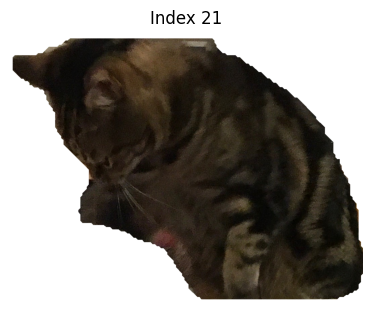

In [15]:
plot_cluster(0)

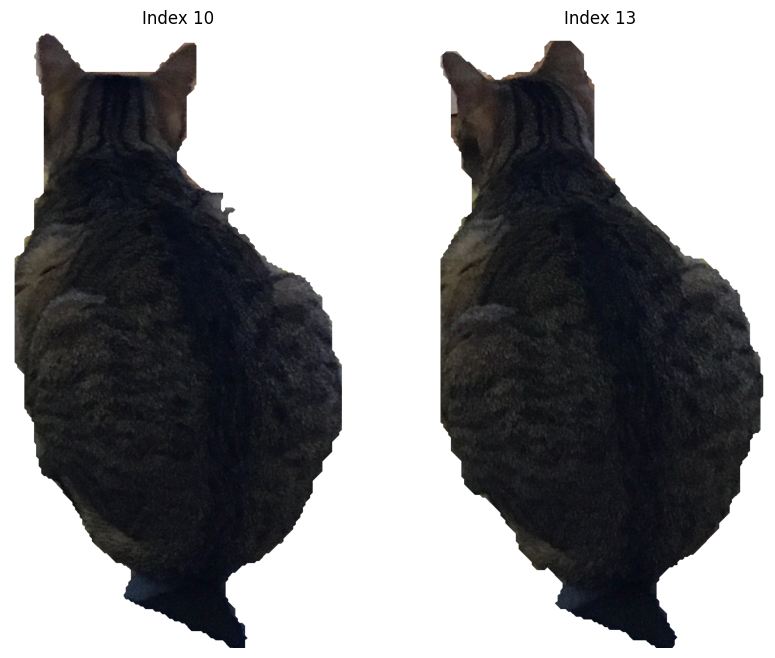

In [16]:
plot_cluster(1)

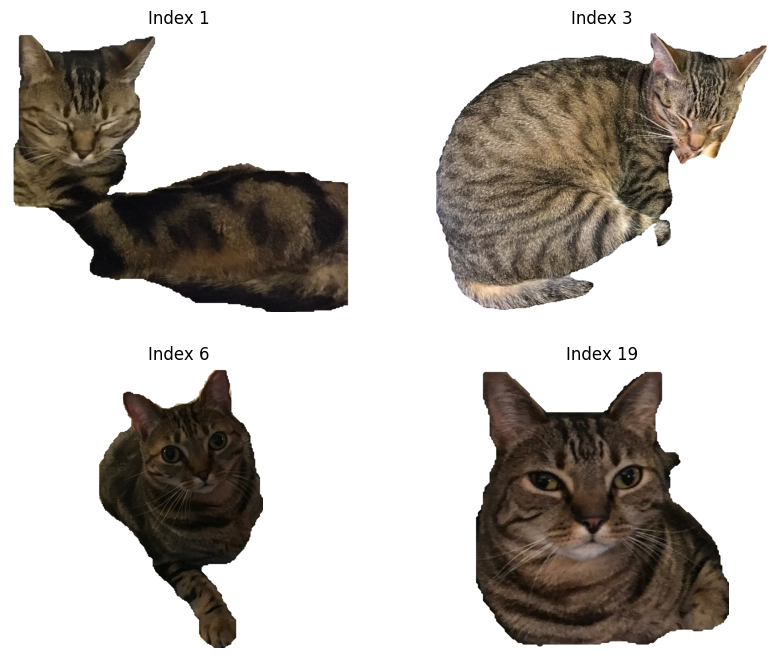

In [17]:
plot_cluster(2)

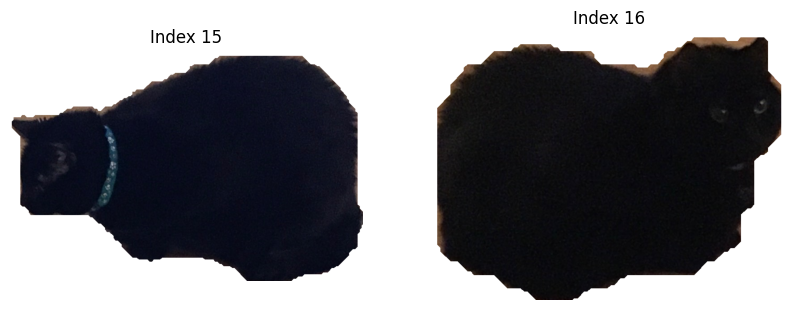

In [18]:
plot_cluster(3)

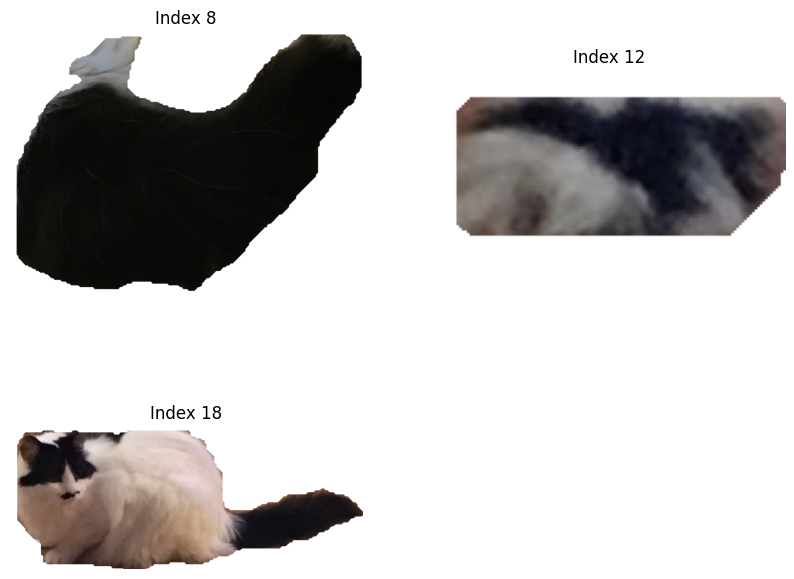

In [19]:
plot_cluster(4)

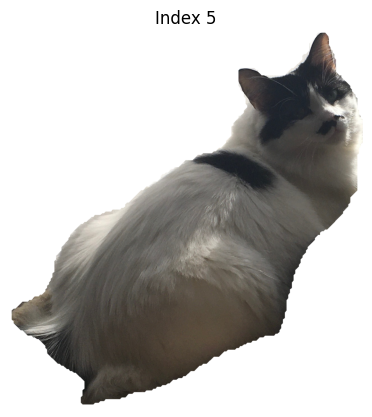

In [20]:
plot_cluster(5)

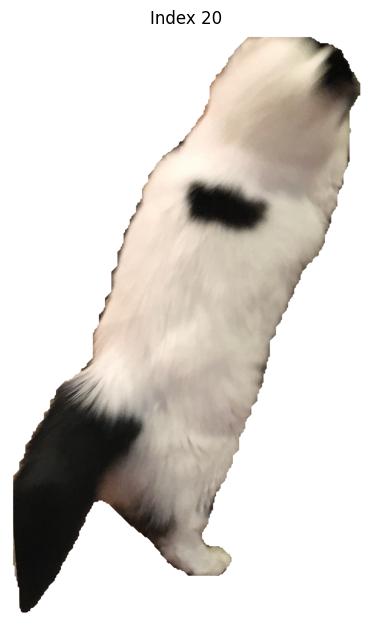

In [21]:
plot_cluster(6)

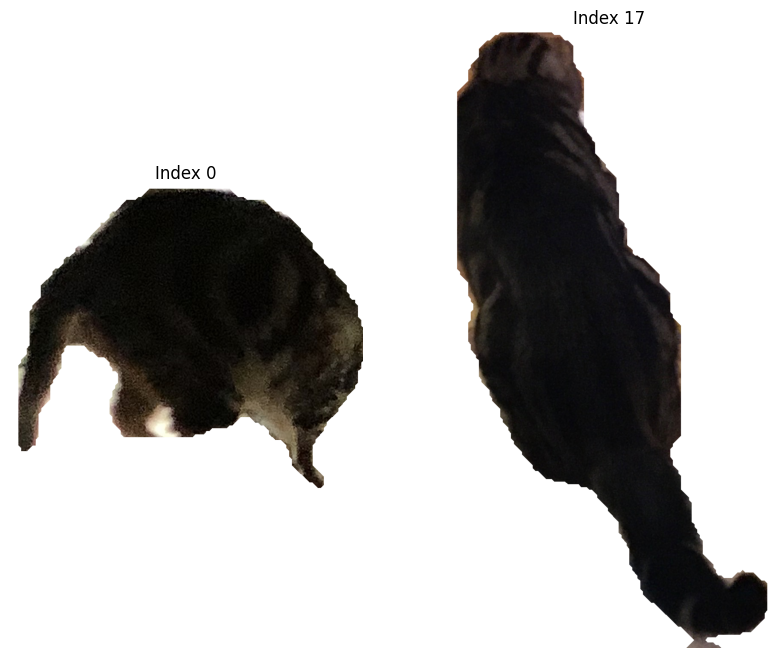

In [22]:
plot_cluster(7)

In [23]:
plot_cluster(8)

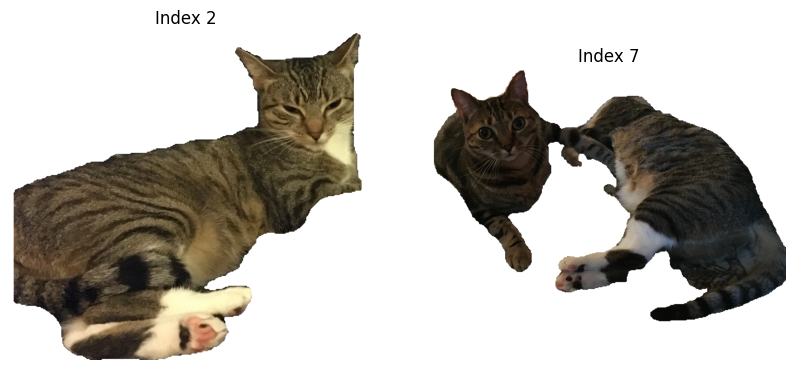

In [24]:
plot_cluster(9)

In [25]:
plot_cluster(10)

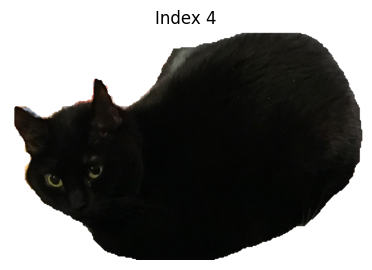

In [26]:
plot_cluster(11)

Given the optimal number of clusters (elbows[0]), perform a [silhouette analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py) on the number of clusters from 2 up to the optimal number of clusters.

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

X = feat


range_n_clusters = range(2,elbows[0])

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Perform a structural similarity analysis.  This has to be done on a pairwise basis.  The code is set up to compare two specific images.

In [ ]:
# See https://stackoverflow.com/questions/11541154/checking-images-for-similarity-with-opencv

from skimage.metrics import structural_similarity
from google.colab.patches import cv2_imshow

# We're reading raw images from the files containing the extracted segmented images, so transform them
# by normalizing the pixels and resizing the image as expected by the VGG model
transformer_nn = tf.keras.Sequential([
        layers.Resizing(244,244),
        layers.Rescaling(1./255)])

transformer1_nn = tf.keras.Sequential([
        layers.Resizing(244,244)])

first = cv2.imread(os.path.join(path_to_cropped_and_classified_images, 'img28.jpg'))
second = cv2.imread(os.path.join(path_to_cropped_and_classified_images, 'img38.jpg'))
# Transform the image by resizing and rescaling
first_resized = transformer_nn(first)
# Convert tensor to numpy array
first_resized = first_resized.numpy()
second_resized = transformer_nn(second)
second_resized = second_resized.numpy()

# Convert images to grayscale
first_gray = cv2.cvtColor(first_resized, cv2.COLOR_BGR2GRAY)
second_gray = cv2.cvtColor(second_resized, cv2.COLOR_BGR2GRAY)

# Compute SSIM between two images
score, diff = structural_similarity(first_gray, second_gray, full=True)
print("Similarity Score: {:.3f}%".format(score * 100))

# The diff image contains the actual image differences between the two images
# and is represented as a floating point data type so we must convert the array
# to 8-bit unsigned integers in the range [0,255] before we can use it with OpenCV
diff = (diff * 255).astype("uint8")

# Threshold the difference image, followed by finding contours to
# obtain the regions that differ between the two images
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

# Highlight differences
mask = np.zeros(first.shape, dtype='uint8')
filled = second.copy()

for c in contours:
    area = cv2.contourArea(c)
    if area > 100:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(first, (x, y), (x + w, y + h), (36,255,12), 2)
        cv2.rectangle(second, (x, y), (x + w, y + h), (36,255,12), 2)
        cv2.drawContours(mask, [c], 0, (0,255,0), -1)
        cv2.drawContours(filled, [c], 0, (0,255,0), -1)

# cv2_imshow(first)
# cv2_imshow(second)
# cv2_imshow(first_resized) # first image
# cv2_imshow(second_resized) # second image
# cv2_imshow(diff) # difference image
# cv2_imshow(mask) # image mask
# cv2_imshow(filled) # filled
# cv2.waitKey()

This approach maps the segmented images to a dense vector representation, and uses cosine similarity to tell how close two images are to one another.  This is implemented in the SentenceTransformer module.  The arbitrary parameter is the threshold above which two images will be clustered together.

In [ ]:
!pip install sentence_transformers

Loading CLIP Model...
Number of images: 22


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Finding duplicate images...
Finding near duplicate images...
Number of near-duplicates: 231
Max score: 0.9855504631996155, min score: 0.5434614419937134
Normalizing scores...
Clustering images based on normalized similarity scores...
Number of high threshold clusters: 3
Number of low threshold clusters: 3


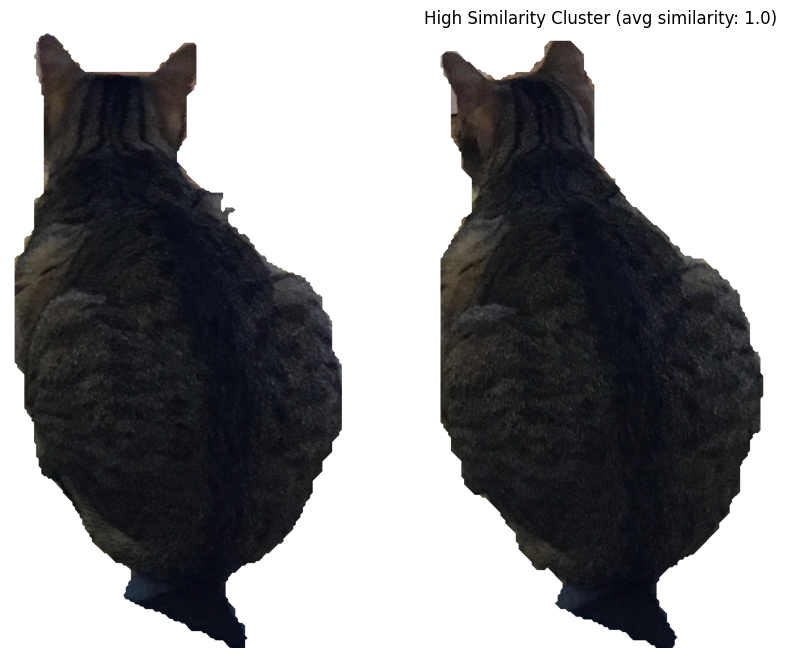

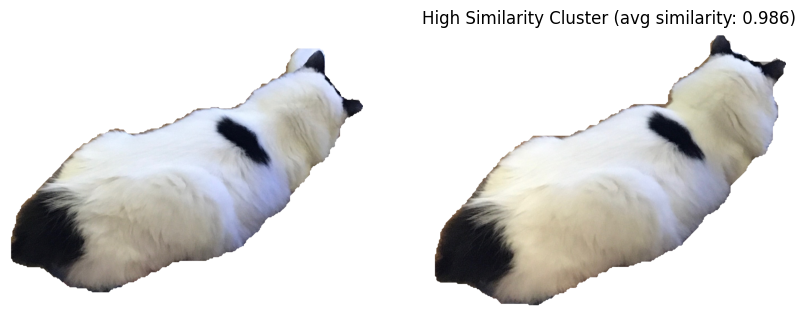

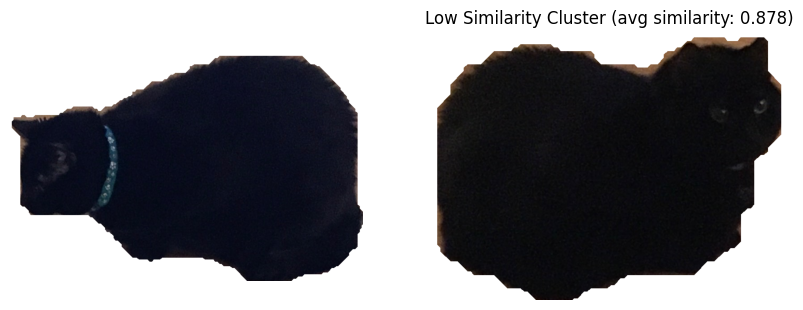

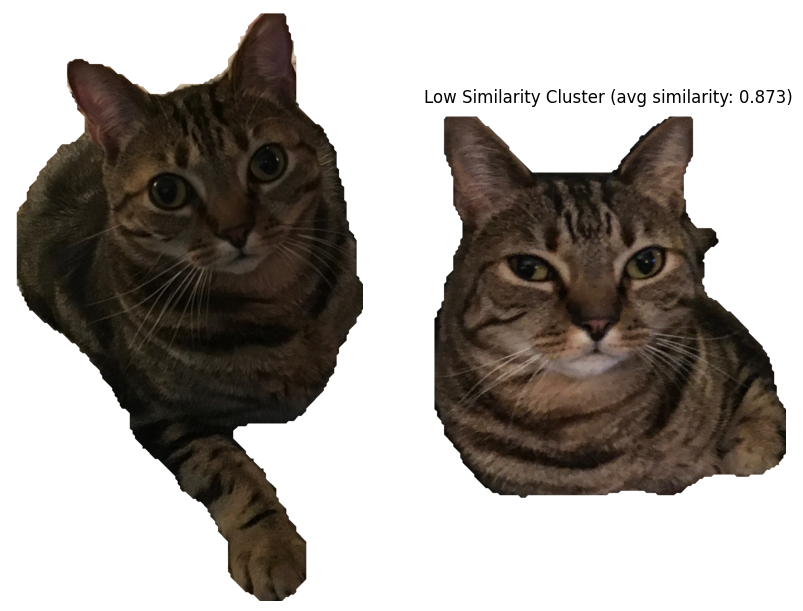

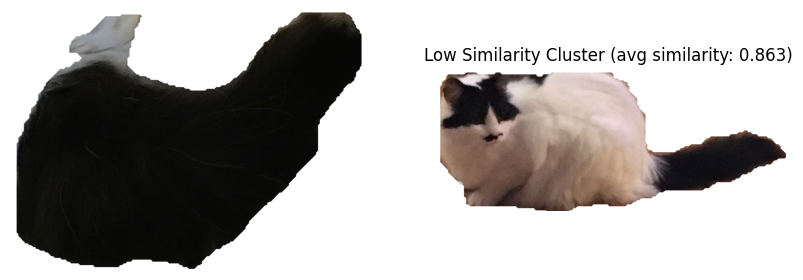

In [13]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import os

# Load the OpenAI CLIP Model
print('Loading CLIP Model...')
model = SentenceTransformer('clip-ViT-B-32')

# Next we compute the embeddings
# To encode an image, you can use the following code:
# from PIL import Image
# encoded_image = model.encode(Image.open(filepath))
image_names = sorted(list(glob.glob(os.path.join(path_to_segmented_images, segmented_image_wildcard_filetype))))
unclustered_image_names = image_names.copy() # used to track which images have been not yet been added to a cluster
print("Number of images: {}".format(len(image_names)))
encoded_image = model.encode([Image.open(os.path.join(path_to_segmented_images, filepath)) for filepath in image_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)

# Now we run the clustering algorithm. This function compares images against
# all other images and returns a list with the pairs that have the highest
# cosine similarity score
processed_images = util.paraphrase_mining_embeddings(encoded_image)

# =================
# DUPLICATES
# =================
print('Finding duplicate images...')
# Filter list for duplicates. Results are triplets (score, image_id1, image_id2) and is scorted in decreasing order
# A duplicate image will have a score of 1.00
# It may be 0.9999 due to lossy image compression (.jpg)
duplicates = [image for image in processed_images if image[0] >= 0.999]

def show_dups(id1, id2):
  fig = plt.figure(figsize=(10,8))
  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(imread(image_names[id1]))
  ax = fig.add_subplot(1, 2, 2)
  ax.imshow(imread(image_names[id2]))
  plt.axis('off')
  plt.title('Duplicates')
  plt.show()

def show_cluster(cluster, high_or_low):
  fig = plt.figure(figsize=(10,8))
  for i, image_name in enumerate(cluster[1:]): # skip the first element (the score)
    ax = fig.add_subplot(1, len(cluster) - 1, i+1)
    ax.imshow(imread(image_name))
    plt.axis('off')
  avg_similarity = str(round(cluster[0] / (len(cluster) - 2), 3))
  if high_or_low == 'high':
    plt.title('High Similarity Cluster (avg similarity: ' + avg_similarity + ')')
  elif high_or_low == 'low':
    plt.title('Low Similarity Cluster (avg similarity: ' + avg_similarity +')')
  else:
    plt.title('Cluster')
  plt.show()

# Output the top X duplicate images
for score, image_id1, image_id2 in duplicates:
    print("\nScore: {:.3f}%".format(score * 100))
    print(image_names[image_id1])
    print(image_names[image_id2])
    show_dups(image_id1, image_id2)

# =================
# NEAR DUPLICATES
# =================
print('Finding near duplicate images...')
# Use a threshold parameter to identify two images as similar. By setting the threshold lower,
# you will get larger clusters which have less similar images in it. Threshold 0 - 1.00
# A threshold of 1.00 means the two images are exactly the same. Since we are finding near
# duplicate images, we can set it at 0.99 or any number 0 < X < 1.00.
threshold = 0.99
near_duplicates = sorted([image for image in processed_images if image[0] < threshold], key=lambda x: x[0], reverse=True)
print('Number of near-duplicates: {}'.format(len(near_duplicates)))
scores_only = [image[0] for image in processed_images if image[0] < threshold]
print('Max score: {}, min score: {}'.format(max(scores_only), min(scores_only)))

# ===============
# Assemble clusters based on similarity scores
#
# Given a CLUSTER_THRESHOLD value, find all pairs of images whose similarity score is
# >= the CLUSTER_THRESHOLD.  For each image in the pair, find an array within the
# clusters array containing that image's path.  If one is found, add the other image's
# pathname to the cluster; otherwise, start a new cluster with the paths of both
# images.  When a path is added to a cluster, remove that path from the list of all
# image paths.  When all image pairs exceeding the threshold have been processed, proceed as follows
# until all paths have been removed from the list of all image paths:
#
# Continue processing pairs as above, adding new clusters and removing paths from the
# list of all paths, but with these changes:
#.    (1) Do not add any path to the clusters created from pairs exceeding the threshold
#.    (2) Do not add to a cluster any path that appears in one of the clusters whose
#         members exceed the threshold.  This may well lead to singleton clusters, and that's OK.
# ===============

HIGH_CLUSTER_THRESHOLD = 0.92
LOW_CLUSTER_THRESHOLD = 0.85
high_threshold_clusters = []
low_threshold_clusters = []

def normalize_scores(scores, processed_images):
    # Normalize the scores
    max_score = max(scores)
    min_score = min(scores)
    normalized_scores = []
    for image in processed_images:
        score = image[0]
        if score == max_score:
            image[0] = 1
        elif score == min_score:
            image[0] = 0
        else:
            image[0] = (score - min_score) / (max_score - min_score)

def is_high_threshold_cluster(row):
    if row[0] >= HIGH_CLUSTER_THRESHOLD:
        return True
    else:
        return False

def is_low_threshold_cluster(row):
    if row[0] < HIGH_CLUSTER_THRESHOLD and row[0] >= LOW_CLUSTER_THRESHOLD:
        return True
    else:
        return False

def get_cluster_image_names(row):
    return [image_names[row[1]], image_names[row[2]]]

def is_one_cat_in_high_threshold_cluster(row):
  file1, file2 = get_cluster_image_names(row)
  for cluster in high_threshold_clusters:
    if file1 in cluster or file2 in cluster:
      return True
  return False

def remove_from_unclustered_images(files):
    for file in files:
        if file in unclustered_image_names:
            unclustered_image_names.remove(file)

def add_to_cluster(row, clusters):
    file1, file2 = get_cluster_image_names(row)
    for cluster in clusters:
        if file1 in cluster:
            if file2 not in cluster:
                cluster[0] += row[0]
                cluster.append(file2)
            return
        elif file2 in cluster:
            if file1 not in cluster:
                cluster[0] += row[0]
                cluster.append(file1)
            return
    # Didn't find file1 or file2 in any cluster, so add a new one
    # First element of every cluster is the total of similarity scores
    # for all pairs added to the cluster
    clusters.append([row[0], file1, file2])


print('Normalizing scores...')
# Normalize the scores
normalize_scores(scores_only, near_duplicates)
print('Clustering images based on normalized similarity scores...')
# Process every pair regardless of similarity score
for row in near_duplicates:
    # Continue processing until every image has been assigned to a cluster
    if len(unclustered_image_names) > 0:
        # If similarity score beats threshold, add row to a cluster in
        # the high threshold cluster list, or add a new cluster there
        if is_high_threshold_cluster(row):
          add_to_cluster(row, high_threshold_clusters)
        # If similarity score is below the high threshold, but above the low threshold,
        # eadd row to a low threshold cluster, but only if neither image has already
        # been assigned to a high threshold cluster
        elif not is_one_cat_in_high_threshold_cluster(row) and is_low_threshold_cluster(row):
          add_to_cluster(row, low_threshold_clusters)
        # Remove file names from list of unclustered images
        file1, file2 = get_cluster_image_names(row)
        remove_from_unclustered_images([file1, file2])
    else:
        break

print('Number of high threshold clusters: {}'.format(len(high_threshold_clusters)))
print('Number of low threshold clusters: {}'.format(len(low_threshold_clusters)))

for cluster in sorted(high_threshold_clusters, key = lambda cluster: cluster[0] / (len(cluster) - 2), reverse=True):
  show_cluster(cluster, 'high')
for cluster in sorted(low_threshold_clusters, key = lambda cluster: cluster[0] / (len(cluster) - 2), reverse=True):
  show_cluster(cluster, 'low')


In [127]:
cluster_threshold = 0.9
df = pd.DataFrame(columns=['cluster_id', 'segmented_image_filename'])
df['cluster_id'] = [-1] * len(image_names)
df['segmented_image_filename'] = image_names


def does_pair_form_cluster(row):
    if row['score'] >= cluster_threshold:
        return True
    else:
        return False


def get_cluster_image_names(row):
    return [image_names[row['image_id1']], image_names[row['image_id2']]]

next_cluster_id = 1

def assign_cluster_id(row):
  global next_cluster_id
  if row['is_cluster']:
      file1, file2 = get_cluster_image_names(row)
      idx1 = df[df['segmented_image_filename'] == file1].index
      idx2 = df[df['segmented_image_filename'] == file2].index
      if len(idx1) == 1 and len(idx2) == 1:
        idx1 = idx1[0]
        idx2 = idx2[0]
        if int(df['cluster_id'].loc[idx1]) > -1:
          df['cluster_id'].loc[idx2] = int(df['cluster_id'].loc[idx1])
        elif int(df['cluster_id'].loc[idx2]) > -1:
          df['cluster_id'].loc[idx1] = int(df['cluster_id'].loc[idx2])
        else:
          df['cluster_id'].loc[idx1] = int(next_cluster_id)
          df['cluster_id'].loc[idx2] = int(next_cluster_id)
          next_cluster_id += 1




df_processed_images = pd.DataFrame(processed_images, columns=['score', 'image_id1', 'image_id2'])
df_processed_images['is_cluster'] = df_processed_images.apply(does_pair_form_cluster, axis=1)
df_processed_images.apply(assign_cluster_id, axis=1)
print('Number of clusters: {}'.format(df['cluster_id'].max()))












Number of clusters: 4


In [128]:
def assign_unclustered_images(row):
  global next_cluster_id
  if row['cluster_id'] == -1:
      # row['cluster_id'] = next_cluster_id
      next_cluster_id += 1
      return next_cluster_id - 1
  else:
      return row['cluster_id']

df['cluster_id'] = df.apply(assign_unclustered_images, axis=1)



In [129]:
df['cluster_id'].max()

20

In [123]:
plot_cluster(1, df)

<Figure size 1000x800 with 0 Axes>

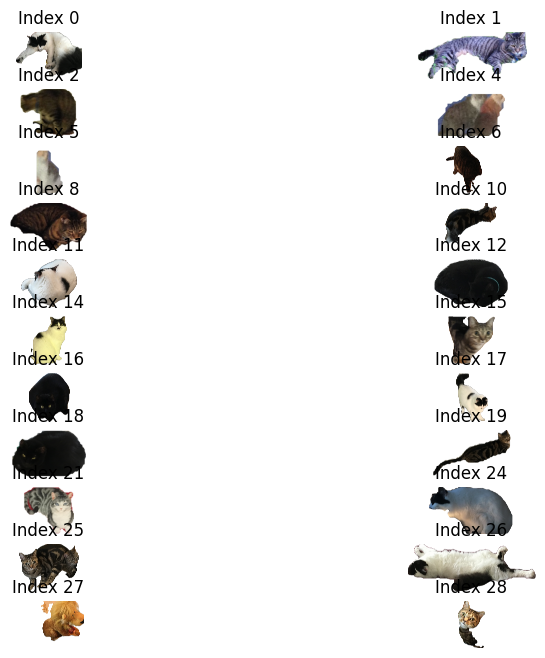

In [124]:
plot_cluster(2, df)

In [125]:
plot_cluster(3, df)

<Figure size 1000x800 with 0 Axes>

In [126]:
plot_cluster(4, df)

<Figure size 1000x800 with 0 Axes>

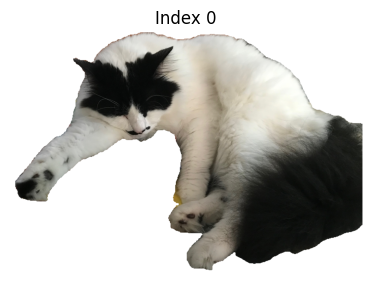

In [103]:
plot_cluster(5, df)

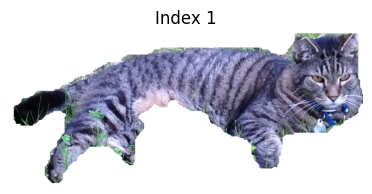

In [104]:
plot_cluster(6, df)

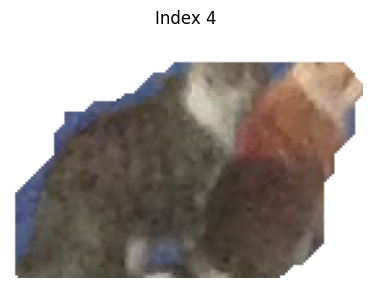

In [105]:
plot_cluster(7, df)

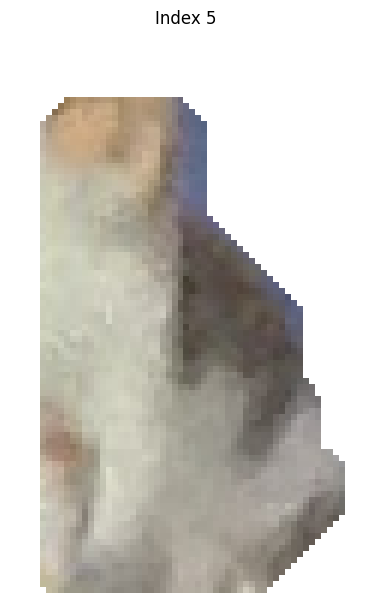

In [106]:
plot_cluster(8, df)

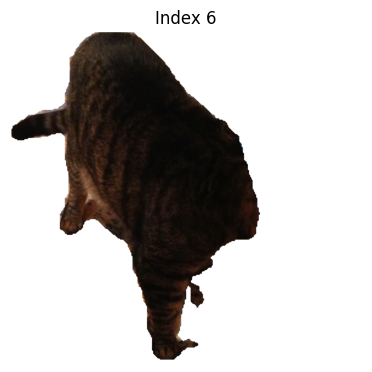

In [107]:
plot_cluster(9, df)

In [95]:
df['cluster_id'].value_counts()[:20]




3     4
2     4
1     3
4     2
13    1
19    1
18    1
17    1
16    1
15    1
14    1
5     1
6     1
12    1
11    1
10    1
9     1
8     1
7     1
20    1
Name: cluster_id, dtype: int64